In [ ]:
# Install all the required libraries
# This notebook was running using Google Colab
!pip install pytket
!pip install jax
!pip install qujax
!pip install pytket-qujax
!pip install pytket-qiskit

In [2]:
# Import the required libraries
from jax import numpy as jnp, random, value_and_grad, jit, grad, jacrev
import matplotlib.pyplot as plt
from pytket.circuit import Circuit
from sympy import Symbol
import numpy as np
import qujax
from pytket.extensions.qujax import tk_to_qujax#, tk_to_qujax_symbolic
from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import AerStateBackend
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interactive, HBox, VBox
import scipy as sp
random_key = random.PRNGKey(0)
import networkx as nx
import jax as jax
import matplotlib.pyplot as plt
from pytket.utils import probs_from_counts 
from pytket.extensions.qiskit import AerBackend, AerStateBackend

In [4]:
# Function definitions
# All the information about the ansatz can be found on the presentation paper.
def Ansatz(num_qubits : int, exp : int, layer : int):
  """
  This function creates a quantum circuit ansatz base on the
  three levels of expressability.
  Str:
    num_qubits(int) : number of qubits for the ansatz.
    exp(int) : expressability circuit.
    layer(int) : number of layers for the ansatz.

  Returns:
    qc: quantum circuit.
    para(list): list with all the parameters in the ansatz.
  """

  para = []                              # storage all the parameters.

  # 1st ansatz.
  if exp == 0:
    qc = Circuit(num_qubits)
    p = 0
    for j in range(layer):
      for i in range(0, num_qubits):
        para.append(Symbol(f'p_{p}'))
        qc.Rx(para[p]/np.pi, i)
        p += 1
      for i in range(0, num_qubits):
        para.append(Symbol(f'p_{p}'))
        qc.Rz(para[p]/np.pi, i)
        p += 1
  # 2nd ansatz.
  elif exp == 1:
    p = 0
    qc = Circuit(num_qubits)
    for i in range(0,num_qubits):
      para.append(Symbol(f'p_{p}'))
      qc.Rx(para[p]/np.pi, i)
      p += 1

    for i in range(0,num_qubits):
      para.append(Symbol(f'p_{p}'))
      qc.Ry(para[p]/np.pi, i)
      p += 1

    for i in range(num_qubits):
      for j in range(num_qubits):
        if i == j:
          p = p 
        else:
          para.append(Symbol(f'p_{p}'))
          qc.CRx(para[p]/np.pi, i, j)
          p += 1
      
    for i in range(0,num_qubits):
      para.append(Symbol(f'p_{p}'))
      qc.Rx(para[p]/np.pi, i)
      p += 1

    for i in range(0,num_qubits):
      para.append(Symbol(f'p_{p}'))
      qc.Ry(para[p]/np.pi, i)
      p += 1
  # 3rd ansatz.
  if exp == 2:
    p = 0
    qc = Circuit(num_qubits)
    for j in range(layer):
      for i in range(0, num_qubits):
        para.append(Symbol(f'p_{p}'))
        qc.Rx(para[p]/np.pi, i)
        p += 1
      for i in range(num_qubits):
        if i+1 == num_qubits:
          qc.CX(i, 0)
        else:
          qc.CX(i, i+1)
      for i in range(0, num_qubits):
        para.append(Symbol(f'p_{p}'))
        qc.Rx(para[p]/np.pi, i)
        p += 1

  return qc, para

# Definition of the cost function for FVQE.
def cost_fun(st, st_old, f_tau, f_tau_2):
    """
    This function return the value of the cost function
    Args:
      st: quantum state
      st_old: old quantum state
      f_tau: value for the filter tau.
      f_tau_2: value for the filter tau square.
    Return:
      cost function.
    """
    st_old_conj = jnp.conj(st_old)
    filt_st = jnp.multiply(f_tau, st)
    aux = jnp.multiply(st_old_conj, filt_st).sum()
    exp_f_2_old = jnp.multiply(st_old_conj, jnp.multiply(f_tau_2, st_old)).sum()
    return (1 - aux.real/jnp.sqrt(exp_f_2_old)).real

def cost(E, bitstr):
    """
    Cost function for the MaxCut problem.
    """
    cost = 0
    bitstr = "0" + bitstr
    for i in range(len(E)):
        cost += -1*E[i][2]*((int(bitstr[E[i][0]]) + int(bitstr[E[i][1]]))%2)
    return cost

def cost_mod(E, bitstr, psuedo_low):
    """
    Cost function modified. (range in [0,1])
    """
    new = -(cost(E, bitstr)-psuedo_low)/psuedo_low
    return new

def Graph(num_qubits):
  """
  Definition of the graph base on the number of qubits.
  """
  deg_seq = [3]*(num_qubits+1)
  G = nx.random_degree_sequence_graph(deg_seq, seed = 350)
  weights = jax.random.uniform(random_key, [len(G.edges())])
  i = 0
  for e in G.edges():
      G[e[0]][e[1]]['weight'] = weights[i]
      i+=1
  E = []
  for i in range(len(G.edges)):
      E.append([list(G.edges)[i][0], list(G.edges)[i][1], float(weights[i])])
  return E, G

def expectation_value_n(parameter, circ, filter_func, tau, backend, E, type, p_keys, pseudo_low, num_shots):
  """
  Calculate the expectation value for the n value.
  """
  s_map = {Symbol(f'p_{k}'): float(parameter[k]) for k in range(len(p_keys))}
  new_circ = circ.copy()
  new_circ.measure_all()
  new_circ.symbol_substitution(s_map)
  compiled_circ = backend.get_compiled_circuit(new_circ)
  handle = backend.process_circuit(compiled_circ, num_shots)
  counts = backend.get_result(handle).get_counts()
  probs  = probs_from_counts(counts)
  exp_val = 0
  for j in probs.keys():
    stri = ""
    for x in j:
      stri += str(x)
    e = cost_mod(E, stri, pseudo_low)
    exp_val += filter_func(e, tau)*probs[j]
  return exp_val

def expectation_value_pm(parameter, circ, filter_func, tau, backend, E, typeo, p_keys, pseudo_low, num_shots):
  """
  Calculate the expectation value.
  """
  grad = []
  for i in range(len(parameter)):
    if typeo == "plus":
      s_map = {Symbol(f'p_{k}'): float(parameter[k]) if k!= i else (float(parameter[k]) + np.pi/2) for k in range(len(p_keys))}
    elif typeo == "minus":
      s_map = {Symbol(f'p_{k}'): float(parameter[k]) if k!= i else (float(parameter[k]) - np.pi/2) for k in range(len(p_keys))}
    new_circ = circ.copy()
    new_circ.measure_all()
    new_circ.symbol_substitution(s_map)
    compiled_circ = backend.get_compiled_circuit(new_circ)
    handle = backend.process_circuit(compiled_circ, num_shots)
    counts = backend.get_result(handle).get_counts()
    probs  = probs_from_counts(counts)
    exp_val = 0
    for j in probs.keys():
      stri = ""
      for x in j:
        stri += str(x)
      e = cost_mod(E, stri, pseudo_low)
      exp_val += filter_func(e, tau)*probs[j]
    grad.append(exp_val)
  return grad

def paramater_shift_rule(parameter, circ, filter_func, filter_2, tau, backend, E, p_keys, pseudo_low, num_shots):
  """
  Calculate the gradient using the parameter shift rule.
  """
  exp_plus = expectation_value_pm(parameter, circ, filter_func, tau, backend, E, "plus", p_keys, pseudo_low, num_shots)
  exp_minus = expectation_value_pm(parameter, circ, filter_func, tau, backend, E, "minus", p_keys, pseudo_low, num_shots)
  exp_lower = expectation_value_n(parameter, circ, filter_2, tau, backend, E, "normal", p_keys, pseudo_low, num_shots)
  gradient = [exp_plus[t] - exp_minus[t] for t in range(len(exp_plus))]
  gradient = gradient/(4*np.sqrt(exp_lower)) # normalize
  return gradient

# Definition of different filters.
def filter_inv(e, tau): return np.power(e, -tau)
def filter_inv2(e, tau):  return np.power(e, -2*tau)

In [6]:
# Hyperparameters

def FVQE(tau, lr, steps, num_qubits, expressability, filter, psr, num_shots, backend, info, layer):

  circ, p_keys = Ansatz(num_qubits, expressability, layer)
  param_to_st = tk_to_qujax(circ, {p_keys[i]: i for i in range(len(p_keys))})
  param_to_st_pi = lambda params: param_to_st(params/jnp.pi)
  params = np.random.random(len(p_keys))
  params = jnp.array(list(params))
  param_to_st(params)

  param_to_cost = lambda param, old_param, f_tau, f_tau_2: cost_fun(param_to_st_pi(param).flatten(), 
                                                                  param_to_st_pi(old_param).flatten(), f_tau, f_tau_2)

  grad_jit = jit(jacrev(param_to_cost))

  E, G = Graph(num_qubits)

  min_cost = 0
  min_str = []
  min_value = []

  for binum in range(2**(num_qubits)):
      bitstr = str(bin(binum)[2:])
      while len(bitstr) < (num_qubits):
          bitstr = '0' + bitstr
      if cost(E, bitstr) == min_cost:
          min_str.append(bitstr)
          min_value.append(binum)
      if cost(E, bitstr) < min_cost:
          min_cost = cost(E, bitstr)
          min_str = [bitstr]
          min_value = [binum]
 
  psuedo_low = min_cost - 0.05

  min_cost = 1
  min_str = []
  f_one = []
  f_two = []

  for binum in range(2**(num_qubits)):
      bitstr = str(bin(binum)[2:])
      while len(bitstr) < (num_qubits):
          bitstr = '0' + bitstr
      if cost_mod(E, bitstr, psuedo_low) == min_cost:
          min_str.append(bitstr)
      if cost_mod(E, bitstr, psuedo_low) < min_cost:
          min_cost = cost_mod(E, bitstr, psuedo_low)
          min_str = [bitstr]

      ### Define the filter function: 
      if filter == 0:
        f_one.append(np.power(cost_mod(E, bitstr, psuedo_low), -tau))
        f_two.append(np.power(cost_mod(E, bitstr, psuedo_low), -2*tau))
      elif filter == 1:
        f_one.append(np.power(np.cos(cost_mod(E, bitstr, psuedo_low)), tau))
        f_two.append(np.power(np.cos(cost_mod(E, bitstr, psuedo_low)), 2*tau))
      elif filter == 2:
        f_one.append(np.power(cost_mod(E, bitstr, psuedo_low), -tau))
        f_two.append(np.power(cost_mod(E, bitstr, psuedo_low), -2*tau))

  #### INITIAL PARAMETERS
  if expressability == 0:
    params = jnp.array([np.pi/2]*num_qubits+[0.0]*(len(p_keys)-num_qubits))
  elif expressability == 1:
    params = jnp.array([0.0]*(len(p_keys)-num_qubits)+[np.pi/2]*num_qubits)
  elif expressability == 2:
    params = jnp.array([0.0]*(len(p_keys)-num_qubits)+[np.pi/2]*num_qubits)

  f_tau = jnp.array(list(f_one))
  f_tau_2 = jnp.array(list(f_two))

  params_evol = [params]

  prob = []

  ### Information about the circuit:
  if info == True:
    print("Number of Parameters: {}".format(len(p_keys)))
    print("Initial Parameters: {}".format(params))
    print("Graph information: {}".format(E))
    print("Graph: ")
    colors = ['r' for node in G.nodes()]
    default_axes = plt.axes(frameon=True)
    pos = nx.spring_layout(G)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
    nx.draw_networkx(G, node_color=colors, node_size=1600, ax=default_axes, pos=pos)

    render_circuit_jupyter(circ)

  for i in range(steps):
      # Get the state
      # Compute the gradients
      if psr == 0:
        g = grad_jit(params, params, f_tau, f_tau_2)
      elif psr == 1:
        g = -paramater_shift_rule(params, circ, filter_inv, filter_inv2, tau, backend, E, p_keys, psuedo_low, num_shots)

      # we normalize the gradient. Any constant factor can be absorved by the learning rate parameter
      g = g / jnp.linalg.norm(g)

      # update params using gradient descent
      params -= lr * g
      params_evol.append(params)

      state = param_to_st_pi(params)
      prob.append(np.linalg.norm(np.array(param_to_st_pi(params).flatten())[min_value]) ** 2)

  return prob, len(p_keys)

Number of Parameters: 30
Initial Parameters: [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        1.5707964 1.5707964 1.5707964
 1.5707964 1.5707964]
Graph information: [[0, 5, 0.3549051284790039], [0, 1, 0.6041990518569946], [0, 3, 0.42758429050445557], [1, 4, 0.23061597347259521], [1, 2, 0.6735497713088989], [2, 3, 0.43953657150268555], [2, 4, 0.2509976625442505], [3, 5, 0.2773057222366333], [4, 5, 0.7678207159042358]]
Graph: 


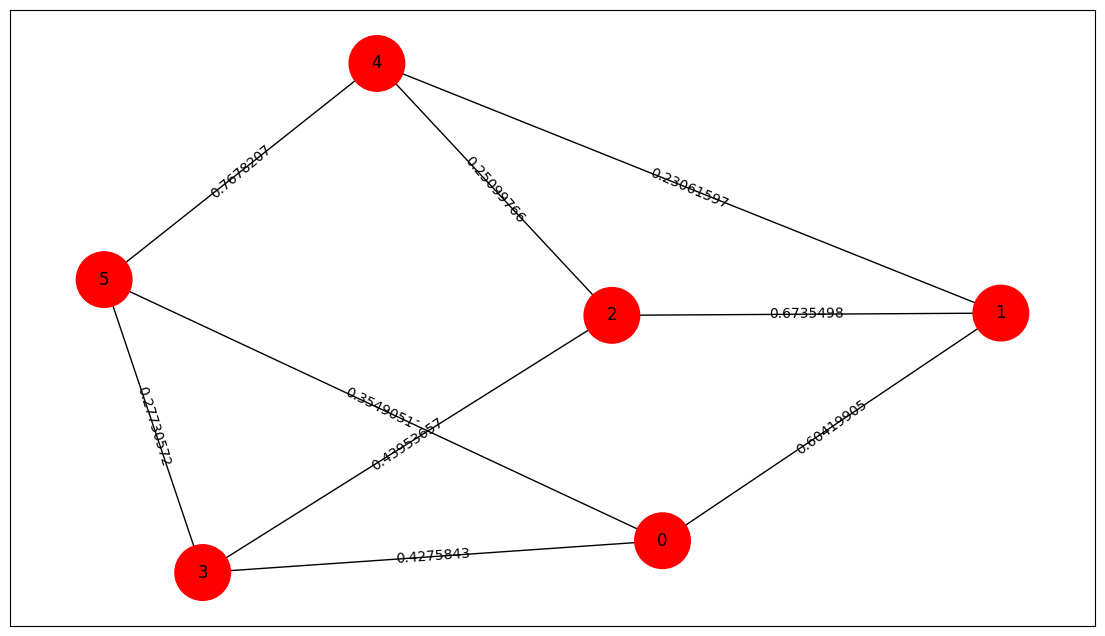

In [7]:
plt.rcParams["figure.figsize"] = [14, 8]
seed = 350
np.random.seed(seed)
jax.random.PRNGKey(seed)

tau = 1    ## Standard value = 1
lr = 0.35  ## Standard value = 0.35
steps = 20 ## Standard value = 20
num_qubits = 5
express_circuit = 2
filter = 0
psr = 0
layers = 3

num_shots = 50
backend = AerBackend()

prob, n_para = FVQE(tau, lr, steps, num_qubits, express_circuit, filter, psr, num_shots, backend, True, layers)

Text(0, 0.5, 'Ground state Probability')

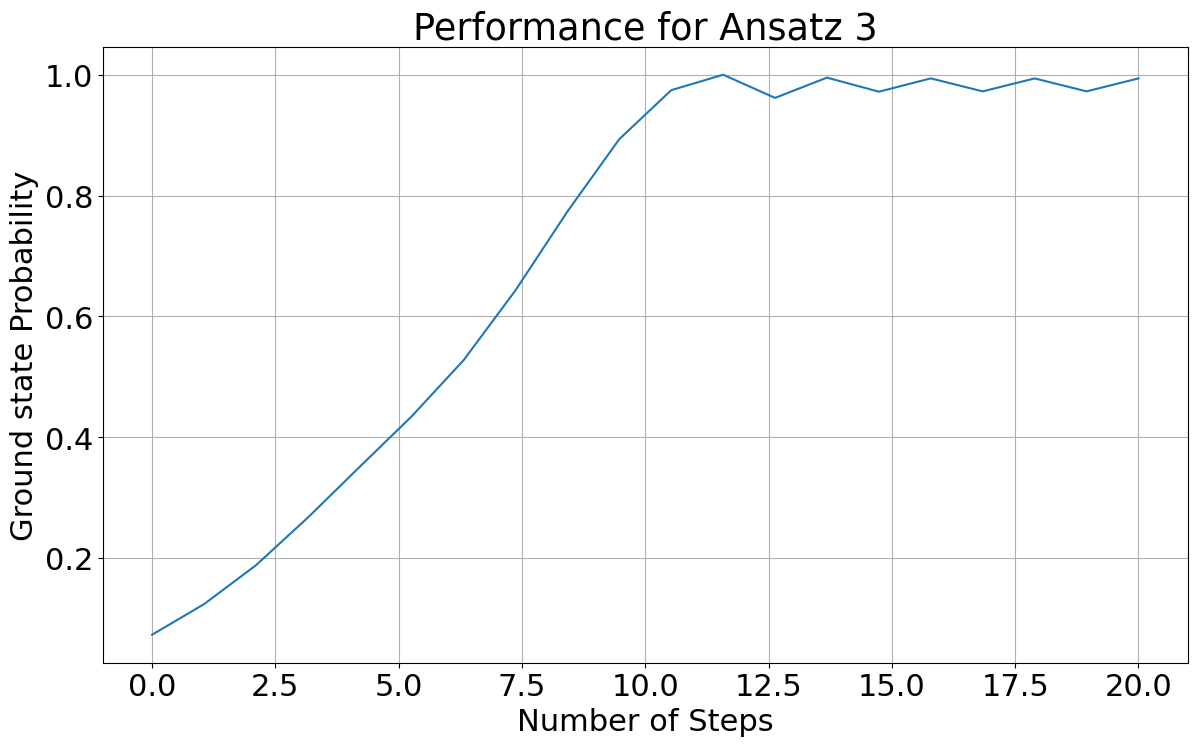

In [9]:
plt.rcParams['legend.fontsize'] = 10
plt.rcParams.update({'font.size': 22})

epochs = np.linspace(0, steps, steps)

plt.plot(epochs, prob)
plt.grid()
plt.title("Performance for Ansatz {}".format(express_circuit+1))
plt.xlabel("Number of Steps")
plt.ylabel("Ground state Probability")

In [ ]:
### PROCEDURE EVERY ANSATZ
seed = 350
np.random.seed(seed)
jax.random.PRNGKey(seed)
# General parameters

tau = 1       ## Standard value = 1
lr = 0.35     ## Standard value = 0.35
steps = 20    ## Standard value = 20
filter = 0
psr = 0
num_shots = 50
layers = 1

for i in range(0,3):
  num_qubits = 3
  val, n_para = FVQE(tau, lr, steps, num_qubits, i, filter, psr, num_shots, backend, False, layers)
  np.save("Anz_{}_nq_3_qjax_para_{}_".format(i, n_para), val)

for i in range(0,3):
  num_qubits = 5
  val, n_para = FVQE(tau, lr, steps, num_qubits, i, filter, psr, num_shots, backend, False, layers)
  np.save("Anz_{}_nq_5_qjax_para_{}_".format(i, n_para), val)

for i in range(0,3):
  num_qubits = 7
  val, n_para = FVQE(tau, lr, steps, num_qubits, i, filter, psr, num_shots, backend, False, layers)
  np.save("Anz_{}_nq_7_qjax_para_{}_".format(i, n_para), val)

for i in range(0,3):
  num_qubits = 9
  val, n_para = FVQE(tau, lr, steps, num_qubits, i, filter, psr, num_shots, backend, False, layers)
  np.save("Anz_{}_nq_9_qjax_para_{}_".format(i, n_para), val)

for i in range(0,3):
  num_qubits = 11
  val, n_para = FVQE(tau, lr, steps, num_qubits, i, filter, psr, num_shots, backend, False, layers)
  np.save("Anz_{}_nq_11_qjax_para_{}_".format(i, n_para), val)

for i in range(0,3):
  num_qubits = 13
  val, n_para = FVQE(tau, lr, steps, num_qubits, i, filter, psr, num_shots, backend, False, layers)
  np.save("Anz_{}_nq_13_qjax_para_{}_".format(i, n_para), val)

Text(0, 0.5, 'Ground state Probability')

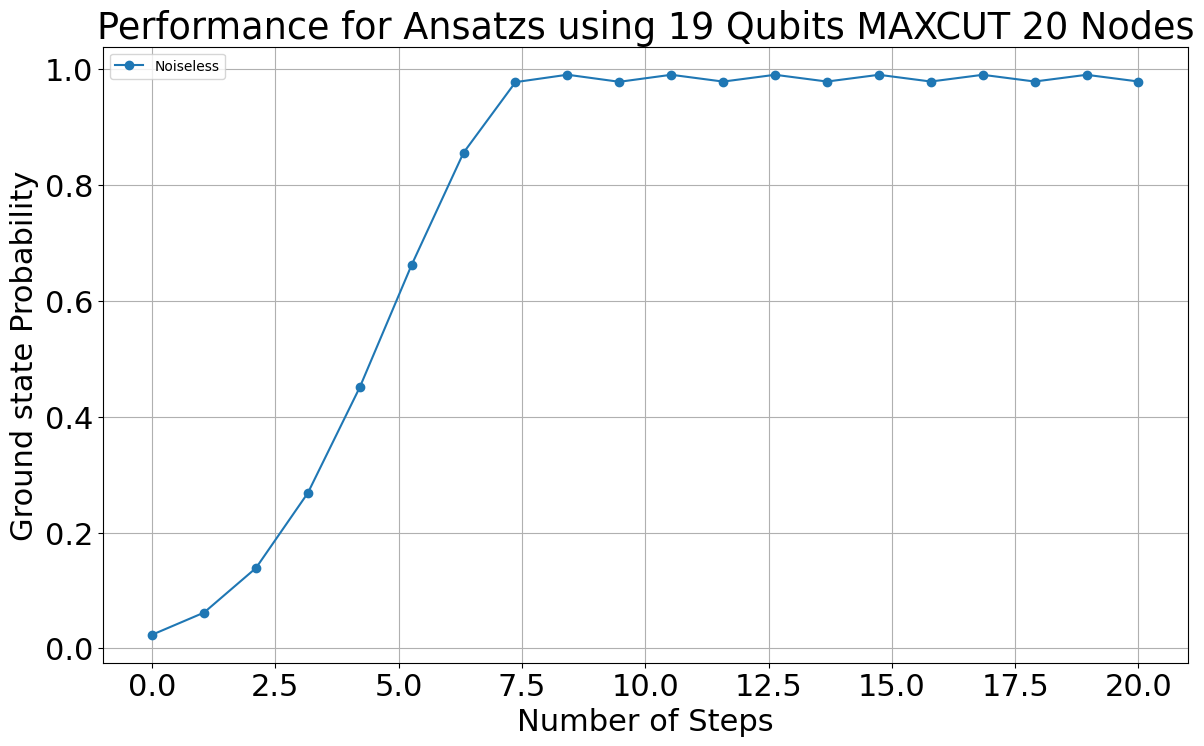

In [11]:
plt.rcParams['legend.fontsize'] = 10
plt.rcParams.update({'font.size': 22})

y = np.load("ICTP_Data/Anz_1_nq_7_qjax_para_70_.npy")
epochs = np.linspace(0, steps, steps)

plt.plot(epochs, y, '-o',label = "Noiseless")

plt.title("Performance for Ansatzs using 19 Qubits MAXCUT 20 Nodes")
plt.legend()
plt.grid()
plt.xlabel("Number of Steps")
plt.ylabel("Ground state Probability")

In [ ]:
### COMPLEX PROCEDURE EVERY ANSATZ
seed = 350
np.random.seed(seed)
jax.random.PRNGKey(seed)
# General parameters

tau = 1       ## Standard value = 1
lr = 0.35     ## Standard value = 0.35
steps = 30    ## Standard value = 20
filter = 0
psr = 0
num_shots = 50
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
num_qubits = 19
layers = 1
anz = 0
val, n_para = FVQE(tau, lr, steps, num_qubits, anz, filter, psr, num_shots, backend, False, layers)
np.save("COM_Anz_{}_nq_19_qjax_para_{}_ly_{}_".format(anz, n_para, layers), val)
#--------------------------------------------------------------------------------------------------
num_qubits = 19
layers = 2
anz = 0
val, n_para = FVQE(tau, lr, steps, num_qubits, anz, filter, psr, num_shots, backend, False, layers)
np.save("COM_Anz_{}_nq_19_qjax_para_{}_ly_{}_".format(anz, n_para, layers), val)
#--------------------------------------------------------------------------------------------------
num_qubits = 19
layers = 3
anz = 0
val, n_para = FVQE(tau, lr, steps, num_qubits, anz, filter, psr, num_shots, backend, False, layers)
np.save("COM_Anz_{}_nq_19_qjax_para_{}_ly_{}_".format(anz, n_para, layers), val)
--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------
num_qubits = 19
layers = 1
anz = 1
val, n_para = FVQE(tau, 0.9, steps, num_qubits, anz, filter, psr, num_shots, backend, False, layers)
np.save("COMLR_Anz_{}_nq_19_qjax_para_{}_ly_{}_lr_09_".format(anz, n_para, layers), val)
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
num_qubits = 19
layers = 1
anz = 2
val, n_para = FVQE(tau, lr, steps, num_qubits, anz, filter, psr, num_shots, backend, False, layers)
np.save("COM_Anz_{}_nq_19_qjax_para_{}_ly_{}_".format(anz, n_para, layers), val)
#--------------------------------------------------------------------------------------------------
num_qubits = 19
layers = 2
anz = 2
val, n_para = FVQE(tau, lr, steps, num_qubits, anz, filter, psr, num_shots, backend, False, layers)
np.save("COM_Anz_{}_nq_19_qjax_para_{}_ly_{}_".format(anz, n_para, layers), val)
#--------------------------------------------------------------------------------------------------
num_qubits = 19
layers = 3
anz = 2
val, n_para = FVQE(tau, lr, steps, num_qubits, anz, filter, psr, num_shots, backend, False, layers)
np.save("COM_Anz_{}_nq_19_qjax_para_{}_ly_{}_".format(anz, n_para, layers), val)
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------------------

In [13]:
Anz_0_ly_1 = np.load("ICTP_Data/COM_Anz_0_nq_19_qjax_para_38_ly_1_.npy")
Anz_0_ly_2 = np.load("ICTP_Data/COM_Anz_0_nq_19_qjax_para_76_ly_2_.npy")
Anz_0_ly_3 = np.load("ICTP_Data/COM_Anz_0_nq_19_qjax_para_114_ly_3_.npy")

Anz_2_ly_1 = np.load("ICTP_Data/COM_Anz_2_nq_19_qjax_para_38_ly_1_.npy")
Anz_2_ly_2 = np.load("ICTP_Data/COM_Anz_2_nq_19_qjax_para_76_ly_2_.npy")
Anz_2_ly_3 = np.load("ICTP_Data/COM_Anz_2_nq_19_qjax_para_114_ly_3_.npy")

Anz_1_ly_1 = np.load("ICTP_Data/COM_Anz_1_nq_19_qjax_para_418_ly_1_.npy")


Text(0, 0.5, 'Ground state Probability')

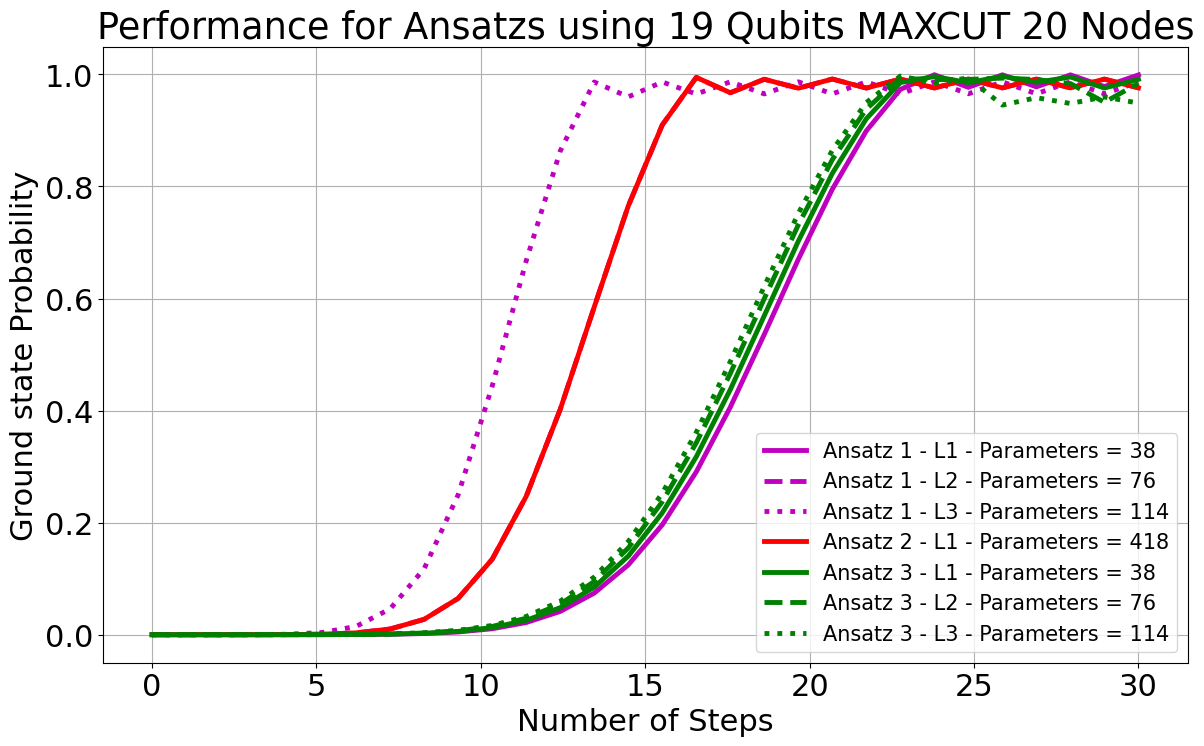

In [14]:
plt.rcParams['legend.fontsize'] = 10
plt.rcParams.update({'font.size': 22})

steps = 30
epochs = np.linspace(0, steps, steps)

plt.plot(epochs, Anz_0_ly_1, color = 'm', label = "Ansatz 1 - L1 - Parameters = 38", linewidth=3.5)
plt.plot(epochs, Anz_0_ly_2, color = 'm', linestyle = '--', label = "Ansatz 1 - L2 - Parameters = 76", linewidth=3.5)
plt.plot(epochs, Anz_0_ly_3, color= 'm', linestyle = ':', label = "Ansatz 1 - L3 - Parameters = 114", linewidth=3.5)

new_date = np.array([3.6016683169540865e-06, 8.022767571600788e-06, 2.2975566994939446e-05, 7.60886341664305e-05, 0.000269236221842082, 0.0009731900707565938, 0.003330192069314286,
 0.010204181059837225, 0.027454160359339008, 0.06460460105815002, 0.13306956437094986, 0.24034563850818813, 0.3818501489351753, 0.5376637238476043, 0.6812738360807238,
 0.7946938141234483, 0.8746908607100181, 0.9267874060642498, 0.9582572595775218, 0.9760908344412798, 0.985917077091333, 0.9913357635516071, 0.9943741039888323, 0.9961200513749056,
 0.9971529273253168, 0.9977821501550501, 0.9981768104240452, 0.9984300342924293, 0.9985963266990758, 0.998708188765022])

#plt.plot(epochs, new_date, color = 'r', linestyle = '--', label = "Smoth", linewidth=3.5)
plt.plot(epochs, Anz_1_ly_1, color = 'r', label = "Ansatz 2 - L1 - Parameters = 418", linewidth=3.5)

plt.plot(epochs, Anz_2_ly_1, color = 'g', label = "Ansatz 3 - L1 - Parameters = 38", linewidth=3.5)
plt.plot(epochs, Anz_2_ly_2, color = 'g', linestyle = '--', label = "Ansatz 3 - L2 - Parameters = 76", linewidth=3.5)
plt.plot(epochs, Anz_2_ly_3, color= 'g', linestyle = ':', label = "Ansatz 3 - L3 - Parameters = 114", linewidth=3.5)

plt.title("Performance for Ansatzs using 19 Qubits MAXCUT 20 Nodes")
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Number of Steps")
plt.ylabel("Ground state Probability")

Text(0, 0.5, 'Ground state Probability')

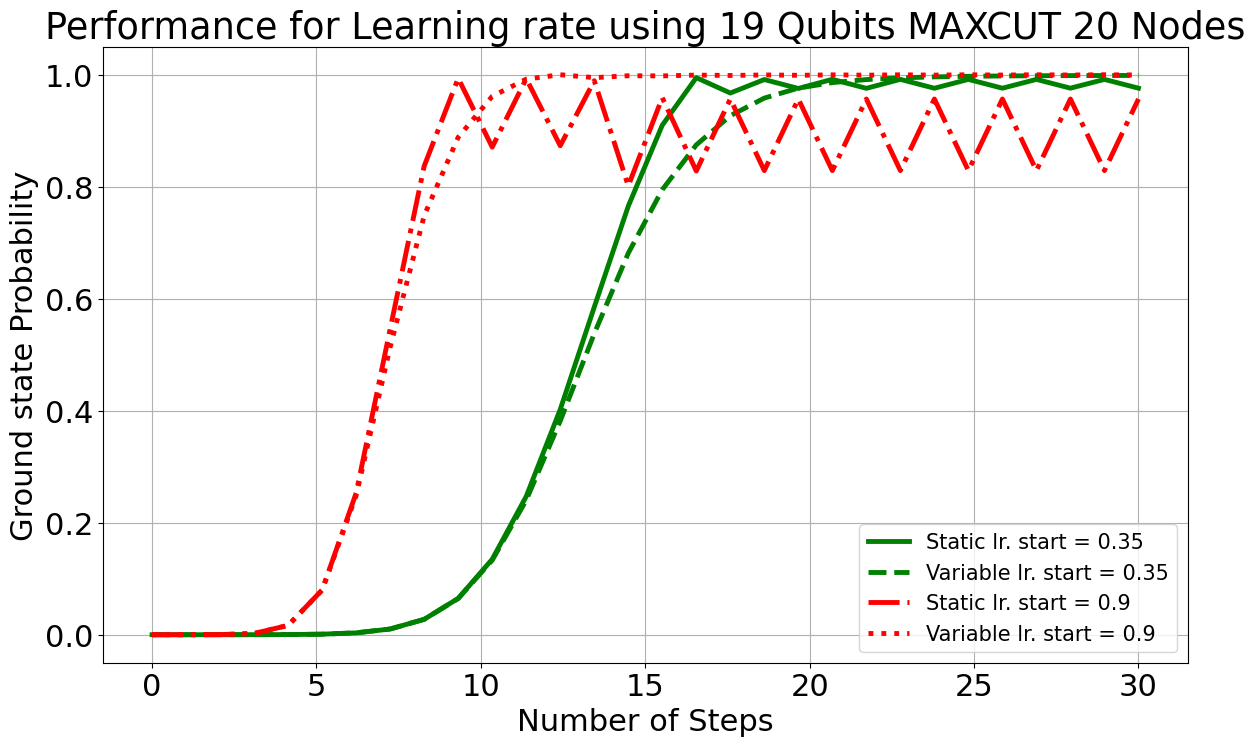

In [15]:
steps = 30
epochs = np.linspace(0, steps, steps)

new_date = np.array([3.6016683169540865e-06, 8.022767571600788e-06, 2.2975566994939446e-05, 7.60886341664305e-05, 0.000269236221842082, 0.0009731900707565938, 0.003330192069314286,
 0.010204181059837225, 0.027454160359339008, 0.06460460105815002, 0.13306956437094986, 0.24034563850818813, 0.3818501489351753, 0.5376637238476043, 0.6812738360807238,
 0.7946938141234483, 0.8746908607100181, 0.9267874060642498, 0.9582572595775218, 0.9760908344412798, 0.985917077091333, 0.9913357635516071, 0.9943741039888323, 0.9961200513749056,
 0.9971529273253168, 0.9977821501550501, 0.9981768104240452, 0.9984300342924293, 0.9985963266990758, 0.998708188765022])

new_date_2 = np.array([6.126181609403313e-06, 2.8830892919968522e-05, 0.0002440260275665719, 0.002285873701014643, 0.016629182354002348, 0.07959940699218127, 0.2485216127390686,
 0.513770843975724, 0.7484384819173471, 0.8883628687105016, 0.9614580631274663, 0.9920545722743555, 0.9999864101871623, 0.9947647606287688, 0.9981689498019399, 0.9978881315187529,
 0.9993001255506897, 0.9986307542926767, 0.9996140375693727, 0.9989625523485337, 0.9997549207184875, 0.9991624917508126, 0.999835855544692, 0.9992992913778984, 0.9998869927863439,
 0.9993985603845346, 0.9999212042118621, 0.9994734027032024, 0.9999445684485444, 0.9995315623633729])

new_date_3 = np.array([6.126181609403313e-06, 2.8830892919968522e-05, 0.0002440282680406464, 0.002286036851909326, 0.016637357705121758, 0.07987339779535674, 0.25315079177948974,
 0.5462167973124821, 0.8369315401262298, 0.9936678831657133, 0.8706681295614125, 0.9929404125155408, 0.8731692334055339, 0.9893159479091231, 0.801468333748435, 0.9589757668300649,
 0.8280096859762267, 0.9566798467418245, 0.8287691818237732, 0.9566305261610211, 0.8287847008678604, 0.9566293602052269, 0.8287847008678604, 0.9566293602052269, 0.8287847008678604,
 0.9566292436096866, 0.8287849179184583, 0.9566292436096866, 0.8287849179184583, 0.9566292436096866])

plt.plot(epochs, Anz_1_ly_1, color = 'g', label = "Static lr. start = 0.35", linewidth=3.5)
plt.plot(epochs, new_date, color = 'g', linestyle = '--', label = "Variable lr. start = 0.35", linewidth=3.5)
plt.plot(epochs, new_date_3, color = 'r', linestyle = '-.', label = "Static lr. start = 0.9", linewidth=3.5)
plt.plot(epochs, new_date_2, color = 'r', linestyle = ':', label = "Variable lr. start = 0.9", linewidth=3.5)

plt.title("Performance for Learning rate using 19 Qubits MAXCUT 20 Nodes")
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Number of Steps")
plt.ylabel("Ground state Probability")

In [16]:
Anz_0_nq_3 = np.load("ICTP_Data/Anz_0_nq_3_qjax_para_6_.npy")
Anz_0_nq_5 = np.load("ICTP_Data/Anz_0_nq_5_qjax_para_10_.npy")
Anz_0_nq_7 = np.load("ICTP_Data/Anz_0_nq_7_qjax_para_14_.npy")
Anz_0_nq_9 = np.load("ICTP_Data/Anz_0_nq_9_qjax_para_18_.npy")
Anz_0_nq_11 = np.load("ICTP_Data/Anz_0_nq_11_qjax_para_22_.npy")
Anz_0_nq_13 = np.load("ICTP_Data/Anz_0_nq_13_qjax_para_26_.npy")

Text(0, 0.5, 'Ground state Probability')

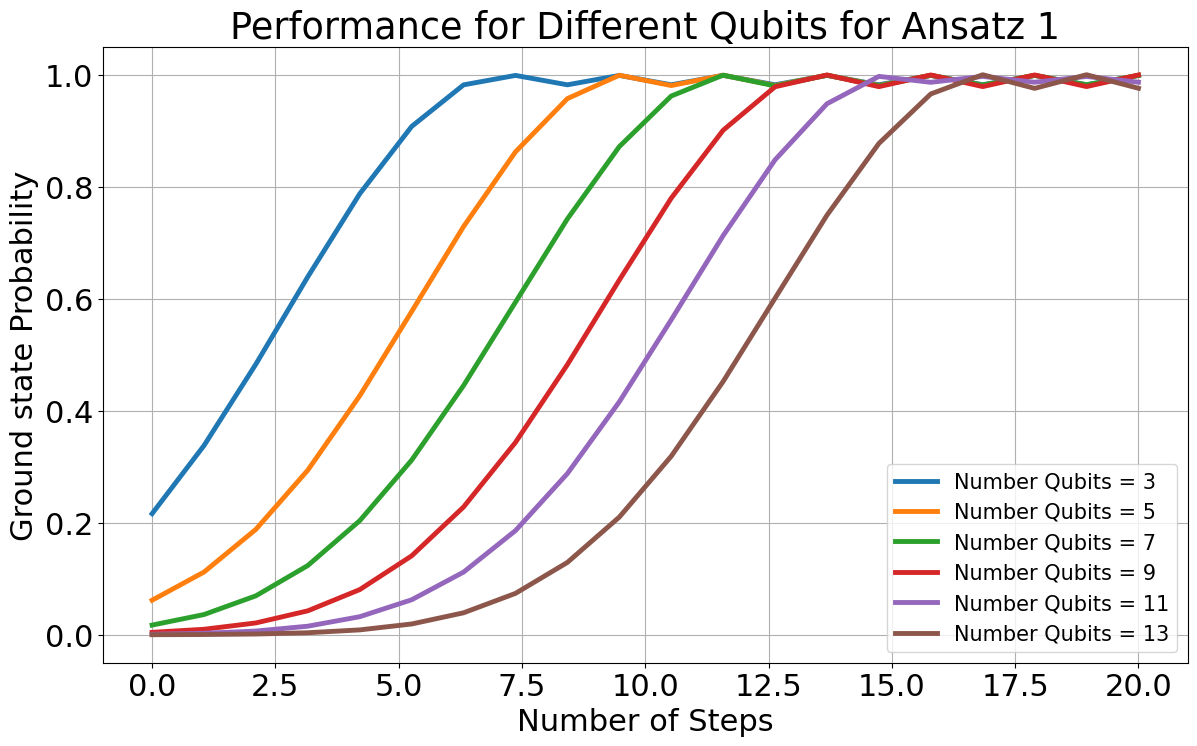

In [17]:
steps = 20
epochs = np.linspace(0, steps, steps)

plt.plot(epochs, Anz_0_nq_3, label = "Number Qubits = 3", linewidth=3.5)
plt.plot(epochs, Anz_0_nq_5, label = "Number Qubits = 5", linewidth=3.5)
plt.plot(epochs, Anz_0_nq_7, label = "Number Qubits = 7", linewidth=3.5)
plt.plot(epochs, Anz_0_nq_9, label = "Number Qubits = 9", linewidth=3.5)
plt.plot(epochs, Anz_0_nq_11, label = "Number Qubits = 11", linewidth=3.5)
plt.plot(epochs, Anz_0_nq_13, label = "Number Qubits = 13", linewidth=3.5)

plt.title("Performance for Different Qubits for Ansatz 1")
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Number of Steps")
plt.ylabel("Ground state Probability")

In [18]:
Anz_1_nq_3 = np.load("ICTP_Data/Anz_1_nq_3_qjax_para_18_.npy")
Anz_1_nq_5 = np.load("ICTP_Data/Anz_1_nq_5_qjax_para_40_.npy")
Anz_1_nq_7 = np.load("ICTP_Data/Anz_1_nq_7_qjax_para_70_.npy")
Anz_1_nq_9 = np.load("ICTP_Data/Anz_1_nq_9_qjax_para_108_.npy")
Anz_1_nq_11 = np.load("ICTP_Data/Anz_1_nq_11_qjax_para_154_.npy")
Anz_1_nq_13 = np.load("ICTP_Data/Anz_1_nq_13_qjax_para_208_.npy")

Text(0, 0.5, 'Ground state Probability')

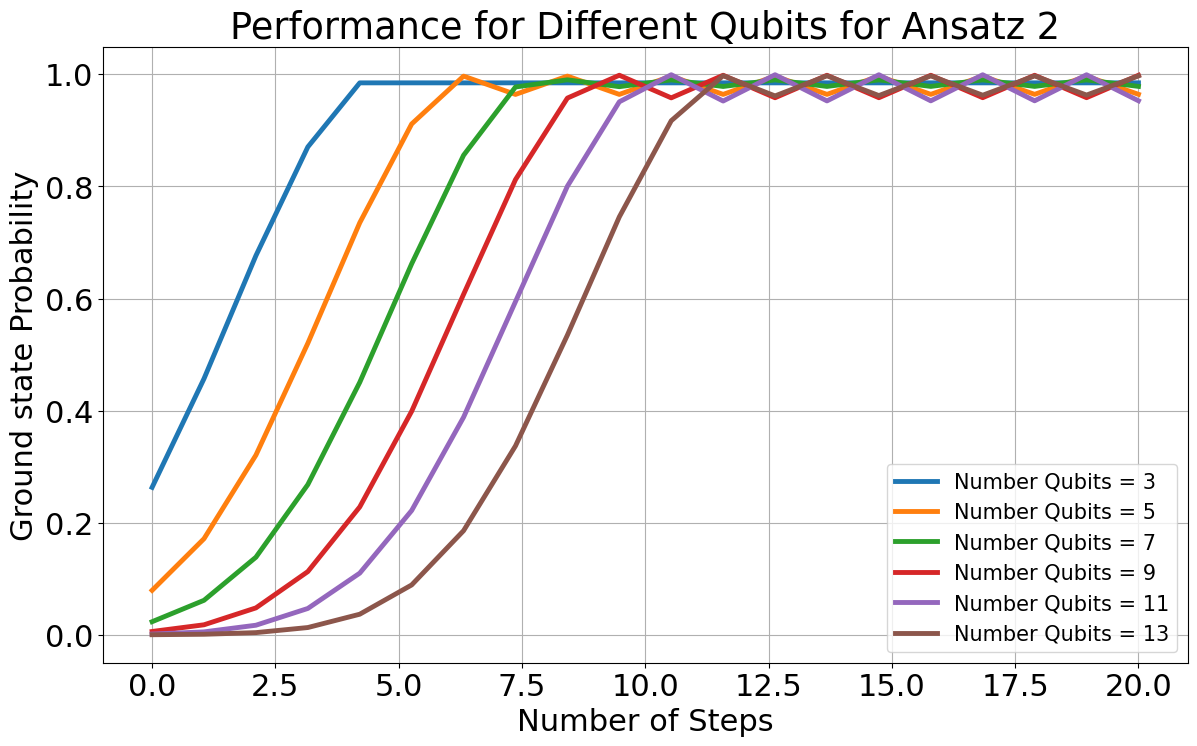

In [19]:
steps = 20
epochs = np.linspace(0, steps, steps)

plt.plot(epochs, Anz_1_nq_3, label = "Number Qubits = 3", linewidth=3.5)
plt.plot(epochs, Anz_1_nq_5, label = "Number Qubits = 5", linewidth=3.5)
plt.plot(epochs, Anz_1_nq_7, label = "Number Qubits = 7", linewidth=3.5)
plt.plot(epochs, Anz_1_nq_9, label = "Number Qubits = 9", linewidth=3.5)
plt.plot(epochs, Anz_1_nq_11, label = "Number Qubits = 11", linewidth=3.5)
plt.plot(epochs, Anz_1_nq_13, label = "Number Qubits = 13", linewidth=3.5)

plt.title("Performance for Different Qubits for Ansatz 2")
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Number of Steps")
plt.ylabel("Ground state Probability")

In [20]:
Anz_2_nq_3 = np.load("ICTP_Data/Anz_2_nq_3_qjax_para_6_.npy")
Anz_2_nq_5 = np.load("ICTP_Data/Anz_2_nq_5_qjax_para_10_.npy")
Anz_2_nq_7 = np.load("ICTP_Data/Anz_2_nq_7_qjax_para_14_.npy")
Anz_2_nq_9 = np.load("ICTP_Data/Anz_2_nq_9_qjax_para_18_.npy")
Anz_2_nq_11 = np.load("ICTP_Data/Anz_2_nq_11_qjax_para_22_.npy")
Anz_2_nq_13 = np.load("ICTP_Data/Anz_2_nq_13_qjax_para_26_.npy")

Text(0, 0.5, 'Ground state Probability')

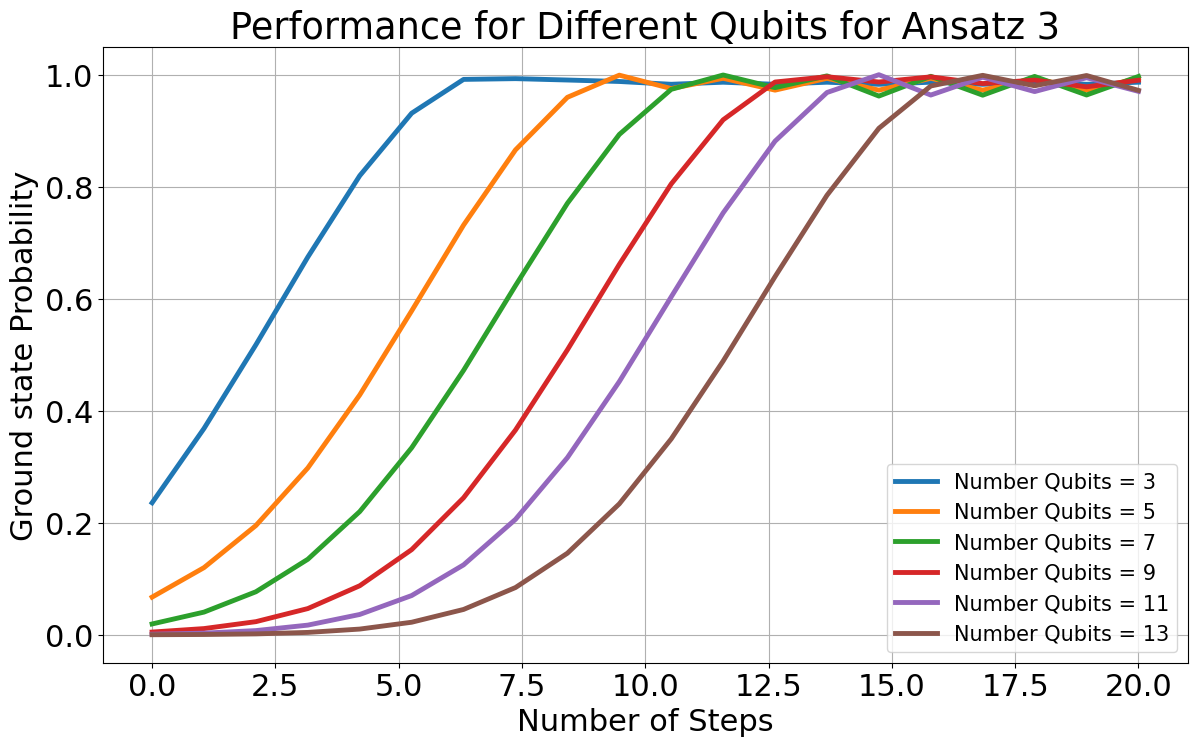

In [21]:
steps = 20
epochs = np.linspace(0, steps, steps)

plt.plot(epochs, Anz_2_nq_3, label = "Number Qubits = 3", linewidth=3.5)
plt.plot(epochs, Anz_2_nq_5, label = "Number Qubits = 5", linewidth=3.5)
plt.plot(epochs, Anz_2_nq_7, label = "Number Qubits = 7", linewidth=3.5)
plt.plot(epochs, Anz_2_nq_9, label = "Number Qubits = 9", linewidth=3.5)
plt.plot(epochs, Anz_2_nq_11, label = "Number Qubits = 11", linewidth=3.5)
plt.plot(epochs, Anz_2_nq_13, label = "Number Qubits = 13", linewidth=3.5)

plt.title("Performance for Different Qubits for Ansatz 3")
plt.legend(fontsize=15)
plt.grid()
plt.xlabel("Number of Steps")
plt.ylabel("Ground state Probability")